In [1]:
%matplotlib inline
import networkx as nx
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
import pickle
from collections import OrderedDict, deque, defaultdict
from nervenet_PPO import NerveNet_GNN
from copy import deepcopy
import random
import json
import pandas as pd
from utils import *

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

In [2]:
# Note: when you see a loss of nan in the prints its okay, if the num of steps is less than the freq of training

In [3]:
# https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861/2

# List of things todo
- ~~Add Double DQN and make sure vanilla DQN formula is correct~~
- ~~Need to track the grads and detach the grads for outputs that arent a part of the actual minibatch fit~~
- ~~Debug multiple props~~
- ~~Track the grad for multiple props~~
- ~~Go through "https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"~~
- ~~After going through ^ see if i need to change my loss because i think that I need to reshape or something so that the vector is summed and then meaned which means that the mean does nothing since there is only one sample per train anyway~~
- ~~Also make sure to add huber loss~~
- ~~Add dikstras to get optimal path from init to goal and use this both as reward and to limit the the path length in an ep~~
- ~~check if adding cuda actually made it slower~~
- ~~Getting a loss of nan sometimes after running it for a while, see whats up~~
- ~~a framework/csv to keep track of all hyperparams when im tuning, even remember things that arent constants such as what feats i use for a node etc.~~
   ~~- Might also want to add time data for certain parts of the code~~
~~- add soft updates for target model~~
- Try adding the link encodings to each node feature cuz right now i just use title
- Try instead of looping through for each prop, expliclty unrolling each prop to make sure that replacing the var node states isnt an issue
- See if i need node feats and goal feats to have grad
- Add in ignore intenral nodes and see if that improves performance

## Grab data and make Graph

In [4]:
G_whole, pages, node_feats, edges = load_data_make_graph('data/animals-D3-small-30K-nodes40-edges202-max10-minout2-minin3_w_features.pkl')

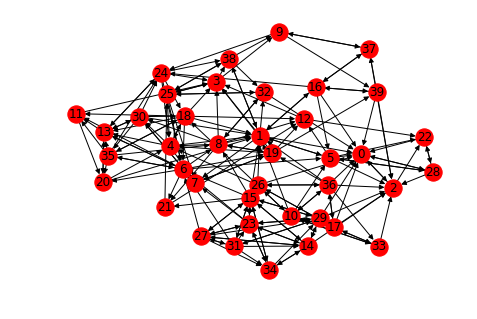

In [5]:
nx.draw_kamada_kawai(G_whole, with_labels=True)
plt.show()

## PPO Agent

In [6]:
class PPOAgent:
    def __init__(self, train_env, eval_env):
        self.train_env = train_env
        self.eval_env = eval_env
        self.gnn = NerveNet_GNN(model_C['node_feat_size'], model_C['node_hidden_size'], 
                                model_C['message_size'], model_C['output_size'], 
                                goal_C['goal_size'], goal_C['goal_opt'], agent_C['critic_agg_weight'], 
                                device).to(device)
        self.state = self.train_env.reset()
        self.ep_step = 0
        self.opt = torch.optim.Adam(self.gnn.parameters(), agent_C['learning_rate'])
        self.gnn.eval()
        
    # Propogate
    def get_action(self, state, env):
        with torch.no_grad():
            action = env.propogate(self.gnn, state)['a'][0].detach().cpu().numpy()
        return action
    
    def _eval_episode(self, test_step):
        state = self.eval_env.reset()
        shortest_path_length = state[4]
        ep_rew = 0
        for step in range(episode_C['max_ep_steps']):
            prediction = self.eval_env.propogate(self.gnn, state)
            action = prediction['a'].cpu().numpy()[0]
            state = deepcopy(state)
            next_state, reward, done, achieved_goal = self.eval_env.step(action, step, state)
            if achieved_goal: assert done
            ep_rew += reward
            test_step += 1
            if done:
                break
            state = deepcopy(next_state)
        return test_step, ep_rew, achieved_goal, shortest_path_length-1, step+1
        
    def eval_episodes(self):
        test_step = 0
        test_info = {}
        test_info['all ep rew'] = []
        test_info['max ep rew'] = float('-inf')
        test_info['min ep rew'] = float('inf')
        test_info['achieved goal'] = []
        test_info['opt steps'] = []
        test_info['steps taken'] = []
        for ep in range(episode_C['eval_num_eps']):
            test_step, ep_rew, achieved_goal, opt_steps, steps_taken = self._eval_episode(test_step)
            test_info['all ep rew'].append(ep_rew)
            test_info['max ep rew'] = max(test_info['max ep rew'], ep_rew)
            test_info['min ep rew'] = min(test_info['min ep rew'], ep_rew)
            test_info['achieved goal'].append(achieved_goal)
            test_info['opt steps'].append(opt_steps)
            test_info['steps taken'].append(steps_taken)
        return (np.array(test_info['max ep rew']).mean(),
                test_info['max ep rew'],
                test_info['min ep rew'],
                np.array(test_info['achieved goal']).sum() / ep,
                np.array(test_info['opt steps']).mean(),
                np.array(test_info['steps taken']).mean())
        
    def train_rollout(self, total_step):
        storage = Storage(episode_C['rollout_length'])
        state = Environment._copy_state(*self.state)
        step_times = []
        for rollout_step in range(episode_C['rollout_length']):
            start_step_time = time.time()
            prediction = self.train_env.propogate(self.gnn, state)
            action = prediction['a'].cpu().numpy()[0]
            next_state, reward, done, achieved_goal = self.train_env.step(action, self.ep_step, state)

            self.ep_step += 1
            if done:
                self.ep_step = 0
                
            storage.add(prediction)
            storage.add({'r': tensor(reward, device).unsqueeze(-1).unsqueeze(-1),
                         'm': tensor(1 - done, device).unsqueeze(-1).unsqueeze(-1),
                         's': state})

            state = Environment._copy_state(*next_state)
            
            total_step += 1
            
            end_step_time = time.time()
            step_times.append(end_step_time - start_step_time)
            
        self.state = Environment._copy_state(*state)

        prediction = self.train_env.propogate(self.gnn, state)
        storage.add(prediction)
        storage.placeholder()
        
        advantages = tensor(np.zeros((1, 1)), device)
        returns = prediction['v'].detach()
        for i in reversed(range(episode_C['rollout_length'])):
            # Disc. Return
            returns = storage.r[i] + agent_C['discount'] * storage.m[i] * returns
            # GAE
            td_error = storage.r[i] + agent_C['discount'] * storage.m[i] * storage.v[i + 1] - storage.v[i]
            advantages = advantages * agent_C['gae_tau'] * agent_C['discount'] * storage.m[i] + td_error
            storage.adv[i] = advantages.detach()
            storage.ret[i] = returns.detach()
        
#         print(returns.shape, td_error.shape, advantages.shape, storage.adv[-1].shape, storage.ret[-1].shape)
        
        actions, log_probs_old, returns, advantages = storage.cat(['a', 'log_pi_a', 'ret', 'adv'])
        states = [storage.s[i] for i in range(storage.size)]
        
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        advantages = (advantages - advantages.mean()) / advantages.std()
        
        # Train
        batch_times = []
        train_pred_times = []
        for _ in range(agent_C['optimization_epochs']):
            sampler = random_sample(np.arange(len(states)), agent_C['minibatch_size'])
            for batch_indices in sampler:
                start_batch_time = time.time()
                
                batch_indices_tensor = tensor(batch_indices, device).long()

                # Important Node: these are tensors but dont have a grad
                sampled_states = [states[i] for i in batch_indices]
                sampled_actions = actions[batch_indices_tensor]
                sampled_log_probs_old = log_probs_old[batch_indices_tensor]
                sampled_returns = returns[batch_indices_tensor]
                sampled_advantages = advantages[batch_indices_tensor]
                
                # Run each state through one at a time and then restack
                prestack_a, prestack_log, prestack_ent, prestack_v = [], [], [], []
                for state, action in zip(sampled_states, sampled_actions):
                    start_pred_time = time.time()
                    
                    pred = self.train_env.propogate(self.gnn, state, action)
                    prestack_a.append(pred['a'])
                    prestack_log.append(pred['log_pi_a'])
                    prestack_ent.append(pred['ent'])
                    prestack_v.append(pred['v'])
                    # print(pred['a'].shape, pred['log_pi_a'].shape, pred['ent'].shape, pred['v'].shape)
                    
                    end_pred_time = time.time()
                    train_pred_times.append(end_pred_time - start_pred_time)
                prediction = {}
                prediction['a'] = torch.stack(prestack_a)
                prediction['log_pi_a'] = torch.cat(prestack_log)
                prediction['ent'] = torch.cat(prestack_ent)
                prediction['v'] = torch.cat(prestack_v)
                
                # Calc. Loss
                self.gnn.train()
                
                ratio = (prediction['log_pi_a'] - sampled_log_probs_old).exp()

                obj = ratio * sampled_advantages
                obj_clipped = ratio.clamp(1.0 - agent_C['ppo_ratio_clip'],
                                          1.0 + agent_C['ppo_ratio_clip']) * sampled_advantages

                # policy loss and value loss are scalars
                policy_loss = -torch.min(obj, obj_clipped).mean() - agent_C['entropy_weight'] * prediction['ent'].mean()

                value_loss = agent_C['value_loss_coef'] * (sampled_returns - prediction['v']).pow(2).mean()

                self.opt.zero_grad()
                (policy_loss + value_loss).backward()
                if agent_C['clip_grads']:
                    nn.utils.clip_grad_norm_(self.gnn.parameters(), agent_C['gradient_clip'])
                self.gnn.graph_grads()
                self.opt.step()
                self.gnn.eval()
                
                end_batch_time = time.time()
                batch_times.append(end_batch_time - start_batch_time)
            
        return total_step, np.array(step_times).mean(), np.array(batch_times).mean(), np.array(train_pred_times).mean()

## Run It

In [7]:
# TODO: Right now its just a collection of static methods, but I might wanna make it an actually useful class and
# give it internal memory
class Environment:
    def __init__(self):
        ...

    @staticmethod
    def step(selected_node_rel, ep_step, state):
        state_copy = Environment._copy_state(*state)
        G_curr, current_nodes, goal_node, goal_feats, shortest_path_length, predecessors = state_copy[:]
        
        selected_node_abs = list(current_nodes.keys())[selected_node_rel]
        achieved_goal = Environment.add_children(G_curr, selected_node_abs, goal_node, current_nodes)
        # Done if goal found or end of ep
        done = True if (ep_step == episode_C['max_ep_steps'] - 1) or achieved_goal else False
        reward = Environment.reward_func(done, achieved_goal, shortest_path_length, ep_step+1)
        predecessors = Environment.get_predecessors(G_curr, current_nodes)
        
        if not done:
            next_state = Environment._copy_state(G_curr, current_nodes, goal_node, goal_feats, shortest_path_length, predecessors)
        else:
            next_state = Environment.reset()
        
        return next_state, reward, done, achieved_goal
    
    # Deep copy everything before it goes into a state
    @staticmethod
    def _copy_state(G_curr, current_nodes, goal_node, goal_feats, shortest_path_length, predecessors):
        G_curr_copy = G_curr.copy()
        current_nodes_copy = current_nodes.copy()
        goal_feats_copy = goal_feats.copy()
        predecessors_copy = deepcopy(predecessors)
        
        return (G_curr_copy, current_nodes_copy, goal_node, goal_feats_copy, shortest_path_length, predecessors_copy)
    
    # For now this is -1 per timestep +5 on terminal for reaching goal, -5 on terminal for not reaching goal
    # And when it reaches the goal, give add (shortest_path_length - 1) - num actions taken (neg number)
    @staticmethod
    def reward_func(terminal, reach_goal, shortest_path_length, num_actions_taken):
        rew = -1
        if terminal:
            if reach_goal:
                assert num_actions_taken >= (shortest_path_length-1)
                rew += other_C['reach_goal_rew']
                rew += ((shortest_path_length-1) - num_actions_taken)  # optimal num actions - num actions taken
            else:
                rew += other_C['not_reach_goal_rew']
        return rew
    
    @staticmethod
    def reset():
        current_try = 0
        while True:
            current_try += 1
    #         if current_try >= 50:
    #              print('Current try for initialize ep is at: {}'.format(current_try))
            init_node = random.randint(0, model_C['num_nodes']-1)
            goal_node = random.randint(0, model_C['num_nodes']-1)
            # restart if goal node is init node, or no path
            if init_node == goal_node or not nx.has_path(G_whole, init_node, goal_node):
                continue
            # restart if shortest path is too long or too short
            shortest_path_length = nx.shortest_path_length(G_whole, init_node, goal_node)
            if shortest_path_length < episode_C['shortest_path_range_allowed_MIN'] or shortest_path_length > episode_C['shortest_path_range_allowed_MAX']:
                continue
            break

        # Get goal feats
        goal_feats = node_feats[goal_node]
        assert goal_feats.shape == (model_C['node_feat_size'],)
        # Make init graph
        G_init = nx.DiGraph()
        G_init.add_node(init_node)
        current_nodes = OrderedDict({init_node: 0})  # Init current nodes dict
        got_goal = Environment.add_children(G_init, init_node, goal_node, current_nodes)
        assert sorted(list(current_nodes.values())) == list(current_nodes.values())
        assert not got_goal
        predecessors = Environment.get_predecessors(G_init, current_nodes)
        return (G_init, current_nodes, goal_node, goal_feats, shortest_path_length, predecessors)
    
    @staticmethod
    def add_children(G_curr, node_indx, goal_node_indx, current_nodes):
        achieved_goal = False
        # Check the children of the node to see if they need to be added to the current graph
        children = G_whole.successors(node_indx)
        for child in children:
            # Add child if not in G and check if goal
            if child not in G_curr:
                G_curr.add_node(child)
                current_nodes.update({child: len(current_nodes)})
                if child == goal_node_indx:
                    achieved_goal = True
            # If the edge doesnt exist add it
            if not G_curr.has_edge(node_indx, child):
                G_curr.add_edge(node_indx, child)
        assert sorted(list(current_nodes.values())) == list(current_nodes.values())
        return achieved_goal
    
    # current_nodes: ordereddict with keys as abs node indices, values as rel node indices (rel to the ordered dict)
    @staticmethod
    def get_predecessors(G_curr, current_nodes):
        all_preds = []  # List of lists
        for node in current_nodes.keys():
            preds_abs = G_curr.predecessors(node)  # abs to all nodes, keys to the dict
            preds_rel = [current_nodes[x] for x in preds_abs]
            all_preds.append(preds_rel)
        return all_preds  # Returns a list of lists with the values being tth rel node indices
    
    @staticmethod
    def propogate(gnn, state, action=None):
        G_curr, current_nodes, goal_node, goal_feats, shortest_path, predecessors = state[:]
        num_nodes = len(current_nodes)
        node_feats_tensor = torch.tensor(node_feats, device=device, requires_grad=True, dtype=torch.float)
        goal_feats_tensor = torch.tensor(goal_feats, device=device, requires_grad=True, dtype=torch.float)
        # Grab the feats of the nodes in the current graph
        node_states = node_feats_tensor[list(current_nodes.keys())] 
        # If goal_input_layer is True then embed the goal by sending it into the input layer
        if goal_C['goal_input_layer']:
            goal_embeddings = gnn.input_model(goal_feats_tensor.reshape(1, -1)).flatten()
            stacked_goal_embeds = torch.stack([goal_embeddings] * num_nodes)
        else:
            stacked_goal_embeds = torch.stack([goal_feats_tensor] * num_nodes)
        for p in range(episode_C['num_props']):
            node_states, prediction = gnn(node_states, p == 0, p == episode_C['num_props']-1, predecessors, stacked_goal_embeds, action)
            assert node_states.shape == (num_nodes, model_C['node_hidden_size'])
        return prediction

In [8]:
def run():
    agent = PPOAgent(Environment(), Environment())
    
    train_step = 0
    rollout_times, batch_times, pred_times = [], [], []
    for r in range(episode_C['num_train_rollouts']+1):
#         print('ROLLOUT {}'.format(r))
        if r != 0 and r % episode_C['eval_freq'] == 0:
#             print('At train step: {}  Rollout step time: {:.4f}  Batch time: {:.4f}  Pred time: {:.4f}'.format(train_step, np.array(rollout_times).mean(), np.array(batch_times).mean(), np.array(pred_times).mean()))
            avg_rew, max_rew, min_rew, ach_perc, avg_opt_steps, avg_steps_taken = agent.eval_episodes()
#             print('Testing summary: Avg ep rew: {:.2f}  Max ep rew: {}  Min ep rew: {}  Achieved goal percent: {:.2f}  Avg opt steps: {:.2f}  Avg steps taken: {:.2f}\n'.format(avg_rew, max_rew, min_rew, ach_perc, avg_opt_steps, avg_steps_taken))
            rollout_times, batch_times, pred_times = [], [], []
        train_step, rollout_step_time, train_batch_time, train_pred_time = agent.train_rollout(train_step)
        rollout_times.append(rollout_step_time); batch_times.append(train_batch_time); pred_times.append(train_pred_time)
    
    # Run eval last time and record
    avg_rew, max_rew, min_rew, ach_perc, avg_opt_steps, avg_steps_taken = agent.eval_episodes()
    print('Final testing summary: Avg ep rew: {:.2f}  Max ep rew: {}  Min ep rew: {}  Achieved goal percent: {:.2f}  Avg opt steps: {:.2f}  Avg steps taken: {:.2f}\n'.format(avg_rew, max_rew, min_rew, ach_perc, avg_opt_steps, avg_steps_taken))

    # Return all info that is appended to the df of experiments (make a dict)
    run_info = {}
    def add_hyp_param_dict(append_letter, dic):
        for k, v in list(dic.items()):
            run_info[append_letter + '_' + k] = v
    add_hyp_param_dict('E', episode_C)
    add_hyp_param_dict('M', model_C)
    add_hyp_param_dict('G', goal_C)
    add_hyp_param_dict('A', agent_C)
    add_hyp_param_dict('O', other_C)
    run_info['eval_avg_ep_rew'] = avg_rew; run_info['eval_max_ep_rew'] = max_rew; run_info['eval_min_ep_rew'] = min_rew
    run_info['eval_ach_goal_perc'] = ach_perc; run_info['eval_avg_opt_steps'] = avg_opt_steps
    run_info['eval_avg_steps_taken'] = avg_steps_taken
    return run_info
        

In [9]:
def run_normal():
    # Load constants
    constants = load_constants('constants/PPO/constants.json')
    
    global episode_C; global model_C; global goal_C; global agent_C; global other_C
    
    episode_C, model_C, goal_C, agent_C, other_C = constants['episode_C'], constants['model_C'], constants['goal_C'], constants['agent_C'], constants['other_C']
    # Fill in missing values
    fill_in_missing_hyp_params(model_C, goal_C, len(pages), len(edges), node_feats.shape[1])

    _ = run()
    
    plt.show()


In [10]:
def run_random_search(num_experiments, grid, df, columns):
    for experiment in range(num_experiments):
        exp_start = time.time()
        
        print('\n --- Running experiment {} --- '.format(experiment))
        
        global episode_C; global model_C; global goal_C; global agent_C; global other_C
        
        # First pick the hyp params to use
        episode_C, model_C, goal_C, agent_C, other_C = select_hyp_params(grid)
        
        fill_in_missing_hyp_params(model_C, goal_C, len(pages), len(edges), node_feats.shape[1])

        run_info = run()
#         assert len(run_info) == len(columns)
        
        # Add to df
        df = df.append(run_info, ignore_index=True)
        # Save fig
        plt.savefig('train-grad-plots/plot_'+str(experiment)+'.png')
        
        exp_end = time.time()
        print('Time taken (m): {:.2f}'.format((exp_end - exp_start) / 60.))
        
        df.to_excel('run-data.xlsx', index=False)
        
#         plt.show()

In [11]:
# refresh_excel('run-data.xlsx')

Final testing summary: Avg ep rew: 3.00  Max ep rew: 3  Min ep rew: -25  Achieved goal percent: 0.74  Avg opt steps: 3.70  Avg steps taken: 13.50



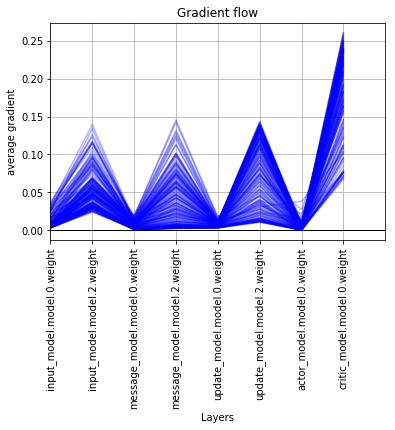

In [12]:
run_normal()

In [13]:
# # Load grid of constants
# grid = load_constants('constants/PPO/constants-grid.json')
# # Load df for saving data
# df = pd.read_excel('run-data.xlsx')
# columns = df.columns.tolist()
# run_random_search(2, grid, df, columns)